In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np

In [2]:
import torch
from tqdm.auto import tqdm
import matplotlib
import itertools
import numpy as np
import os
import csv

# Set constant below to True if no GPU should be used. Otherwise, GPU will be used by default if exists.
CPU_ONLY = False
# If CLUSTER is False, progress bars are shown via tqdm. Otherwise, they are surpressed to reduce stdout.
CLUSTER = False

def find_key_by_value(mydict,value):
    return list(mydict.keys())[list(mydict.values()).index(value)]


def get_device():
    return torch.device("cuda:0" if (not CPU_ONLY and torch.cuda.is_available()) else "cpu")

def set_cluster(is_cluster):
    global CLUSTER 
    CLUSTER = is_cluster
    if CLUSTER:
        matplotlib.use('Agg')

def is_cluster():
    return CLUSTER

def track(iterator, **kwargs):
    if not CLUSTER:
        return tqdm(iterator, **kwargs)
    else:
        return iterator

In [3]:
def z_score_normalize(input_tensor):
    mean = torch.mean(input_tensor)  # 计算均值
    std = torch.std(input_tensor)  # 计算标准差
    normalized_tensor = (input_tensor - mean) / std  # 标准化
    return normalized_tensor

In [4]:
# 1. Load image
resize_shape = 128
circle_image = Image.open('./data/circle2C/circle.png').convert('L').resize((resize_shape,resize_shape))
c_image = Image.open('./data/circle2C/C.png').convert('L').resize((resize_shape,resize_shape))
circle_image=torch.from_numpy(np.array(circle_image)).float().unsqueeze(0).unsqueeze(0)
c_image=torch.from_numpy(np.array(c_image)).float().unsqueeze(0).unsqueeze(0)
circle_image = z_score_normalize(circle_image)
c_image = z_score_normalize(c_image)
print("circle_image.shape: ", circle_image.shape)
print("c_image.shape: ", c_image.shape)

circle_image.shape:  torch.Size([1, 1, 128, 128])
c_image.shape:  torch.Size([1, 1, 128, 128])


In [5]:
import numpy as np
from scipy.sparse import coo_matrix, bmat


def conv_kernel_2_sparse_mat(conv_kernel, height, width):
    # 初始化稀疏矩阵的数据列表
    rows, cols, data = [], [], []
    offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    
    for i in range(height):
        for j in range(width):
            img_idx = i * width + j  # 计算当前像素在展平向量中的索引
            
            for k, (di, dj) in enumerate(offsets):
                # 计算卷积核偏移位置的行列索引，使用wrap边界条件
                ni = (i + di) % height
                nj = (j + dj) % width
                neighbor_idx = ni * width + nj  # 相邻像素的展平索引
                
                # 保存索引和卷积核值
                rows.append(img_idx)
                cols.append(neighbor_idx)
                data.append(conv_kernel[di + 1, dj + 1])  # 卷积核值
                
    # 构造稀疏矩阵，形状为 (height * width, height * width)
    conv_sparse_matrix = coo_matrix((data, (rows, cols)), shape=(height * width, height * width))
    return conv_sparse_matrix


def elastic_energy_sparse_matrix(height, width, mu=2, lam=1, delta_height=1, delta_width=1):
    matrix_26 = np.array([
        [0, -(2*mu + lam) * delta_height**-2, 0],
        [-mu * delta_width**-2, mu * (4 * delta_height**-2 + 2 * delta_width**-2) + 2 * lam * delta_height**-2, -mu * delta_width**-2],
        [0, -(2*mu + lam) * delta_height**-2, 0]
    ])
    print(matrix_26)
    matrix_27 = np.array([
        [-(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, (mu + lam) / 4 * delta_height**-1 * delta_width**-1],
        [0, 0, 0],
        [(mu + lam) / 4 * delta_height**-1 * delta_width**-1, 0, -(mu + lam) / 4 * delta_height**-1 * delta_width**-1]
    ])
    print(matrix_27)
    matrix_28 = np.array([
        [0, -mu * delta_height**-2, 0],
        [-(2*mu + lam) * delta_width**-2, mu * (4 * delta_width**-2 + 2 * delta_height**-2) + 2 * lam * delta_width**-2, -(2*mu + lam) * delta_width**-2],
        [0, -mu * delta_height**-2, 0]
    ])
    print(matrix_28)
    # 将卷积矩阵转换为稀疏矩阵
    matrix_26_sparse = conv_kernel_2_sparse_mat(matrix_26, height, width)
    matrix_27_sparse = conv_kernel_2_sparse_mat(matrix_27, height, width)
    matrix_28_sparse = conv_kernel_2_sparse_mat(matrix_28, height, width)
    
    # 使用 bmat 构造稀疏矩阵 block
    matrix_H = bmat([
        [matrix_28_sparse, matrix_27_sparse],
        [matrix_27_sparse, matrix_26_sparse]
    ], format='coo')
    
    return matrix_H


In [6]:
a = elastic_energy_sparse_matrix(resize_shape,resize_shape).toarray()


[[ 0. -5.  0.]
 [-2. 14. -2.]
 [ 0. -5.  0.]]
[[-0.75  0.    0.75]
 [ 0.    0.    0.  ]
 [ 0.75  0.   -0.75]]
[[ 0. -2.  0.]
 [-5. 14. -5.]
 [ 0. -2.  0.]]


In [7]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# # 将 PyTorch 张量转换为 NumPy 数组
# # array_2d = train_target[0].numpy().squeeze()

# # 绘制热力图
# plt.figure(figsize=(6, 5))
# plt.imshow(-a, cmap='gray', aspect='auto')
# plt.colorbar(label='Intensity')
# plt.title('2D Array Heatmap')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()


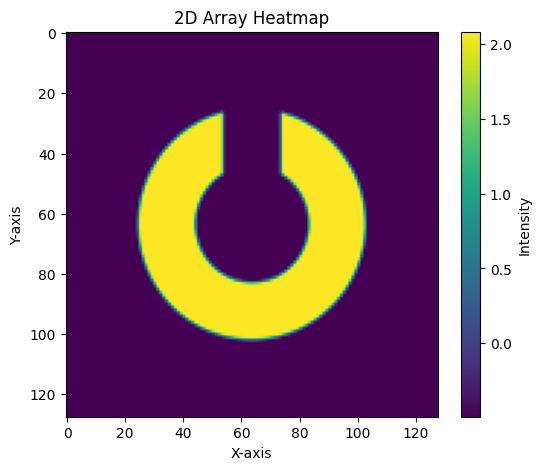

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例的 2D 张量
tensor_2d = torch.rand(10, 10)  # 创建 10x10 的随机张量

# 将 PyTorch 张量转换为 NumPy 数组
array_2d = c_image.numpy().squeeze()

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(array_2d, cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('2D Array Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [9]:
import torch

def approximate_hessian(func, inputs, epsilon=1e-7):
    """
    Approximate the Hessian matrix using finite differences.
    func: Forward pass function that computes the loss.
    inputs: Tensor to compute the Hessian for.
    epsilon: Perturbation size.
    """
    # Compute the initial gradient
    initial_grad = torch.autograd.grad(func(inputs), inputs, create_graph=True)[0]

    length_x = inputs.numel() // 2

    perturbed_inputs = inputs.clone()

    # Perturb the first half of the inputs
    perturbed_inputs.view(-1)[:length_x] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the first block (A)
    hessian_column_x = (perturbed_grad - initial_grad).view(-1) / epsilon

    perturbed_inputs = inputs.clone()

    # Perturb the second half of the inputs
    perturbed_inputs.view(-1)[length_x:] += epsilon

    # Compute the perturbed gradients
    perturbed_grad = torch.autograd.grad(func(perturbed_inputs), perturbed_inputs, create_graph=True)[0]

    # Compute the Hessian for the second block (D)
    hessian_column_y = (perturbed_grad - initial_grad).view(-1) / epsilon

    # Now we want to form the block diagonal Hessian matrix:
    # Block structure: 
    # [Diag(A), Diag(C); Diag(B), Diag(D)]
    A = hessian_column_x[:length_x]
    B = hessian_column_x[length_x:]
    C = hessian_column_y[:length_x]
    D = hessian_column_y[length_x:]

    # Create the block diagonal Hessian matrix
    hessian_matrix = torch.zeros(2 * length_x, 2 * length_x, device=inputs.device)

    # Diagonal blocks (A, D) on the diagonal
    hessian_matrix[:length_x, :length_x] = torch.diag(A)
    hessian_matrix[length_x:, length_x:] = torch.diag(D)

    # Off-diagonal blocks (B, C)
    hessian_matrix[:length_x, length_x:] = torch.diag(B)
    hessian_matrix[length_x:, :length_x] = torch.diag(C)

    hessian_matrix = (hessian_matrix + hessian_matrix.t()) / 2
    return hessian_matrix


In [10]:
circle_image.numel()

16384

In [11]:
from register.SpatialTransformer2 import SpatialTransformer2
from register.LocalDisplacementEnergy import ElasticEnergy
from torch.autograd.functional import hessian

## 判断a是不是numpy
if isinstance(a,np.ndarray):
     a=torch.from_numpy(a).float()  # 转换为tensor

loss_fn=nn.MSELoss(reduction='sum')   # MSE作为loss
model=SpatialTransformer2(circle_image.shape[2:],10,circle_image,c_image,loss_fn)  # 生成模型
device=torch.device("cuda:7")  # 使用GPU
model.move_to(device)
a = a.to(device)
basic_flow_shape = model.basic_flows.shape
eta = 1

In [17]:
eye_matrix = eta * torch.eye(2 * resize_shape ** 2).to(device)
t = track(range(100), leave=False, desc="Epoch iteration")
for i in  t:
    loss=model()  # 计算loss
    if hasattr(t, "set_description"):
            t.set_description("Model update loop, loss: %4.2f" % (2*loss/circle_image.numel()))

    # print(loss)
        # 计算梯度
    loss.backward(retain_graph=True)
    grad = model.basic_flows.grad.view(-1, 1)
    hess = approximate_hessian(model, model.basic_flows)
    # print(hess.sum())
    with torch.no_grad():
        model.basic_flows.data  = (model.basic_flows.view(-1,1) - torch.linalg.solve(a+hess+eye_matrix, grad + a @ model.basic_flows.view(-1, 1))).view(*basic_flow_shape)

Epoch iteration:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
predict_image=model.predict_image()  # 获取预测图像

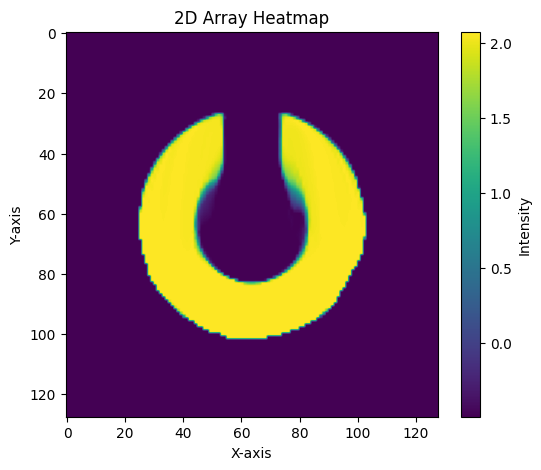

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 创建一个示例的 2D 张量
tensor_2d = torch.rand(10, 10)  # 创建 10x10 的随机张量

# 将 PyTorch 张量转换为 NumPy 数组

# 绘制热力图
plt.figure(figsize=(6, 5))
plt.imshow(predict_image.squeeze().cpu().detach().numpy(), cmap='viridis', aspect='auto')
plt.colorbar(label='Intensity')
plt.title('2D Array Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [ ]:
from register.SpatialTransformer2 import SpatialTransformer2
from register.LocalDisplacementEnergy import BendingEnergy
loss_fn=nn.MSELoss()   # MSE作为loss

model=SpatialTransformer2(circle_image.shape[2:],10,circle_image,c_image,loss_fn)  # 生成模型
device=torch.device("cuda:7")  # 使用GPU
model.move_to(device)


opt=torch.optim.Adam(model.parameters(), lr=0.05)  # Adam优化器

bending_energy = BendingEnergy(alpha=1, dimension=2)  # 弯曲能量作为正则项

for i in range(20000):
    loss=model()  # 计算loss
    flows=[flows for flows in model.parameters()][0]  # 获取流场
    loss += bending_energy(flows)  # 加上正则项

    if (i + 1) % 200 == 0:
        print(i, " loss(with reg): ", loss)  # 打印loss

    opt.zero_grad()  # 梯度清零
    loss.backward(retain_graph=True)  # 反向传播
    opt.step()  # 更新参数

In [ ]:
model.basic_flows.shape

In [ ]:
loss

In [ ]:
model.origin_image